### Prediction model for DAENERGY

In the following notebook are considered two different approach to predict the price of DAENERGY

In [229]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from src.process_data import pivot_data, create_index, clean_data

#### Loading and cleaning data

- Pivot table
- It's considered data from 2017-07-05 to 2017-10-30
- There are some missing values. Those values where computed using replicating the value of the previous observation (To obtain an index with hourly frequency and obtain forecasts using stats models.
- It's created the index with TRADEDATE and HOUROFWEEK. Finally we obtain the exact date and time of trade.


In [230]:
df = pivot_data('data/Data.txt')
df = clean_data(df)
df = create_index(df)

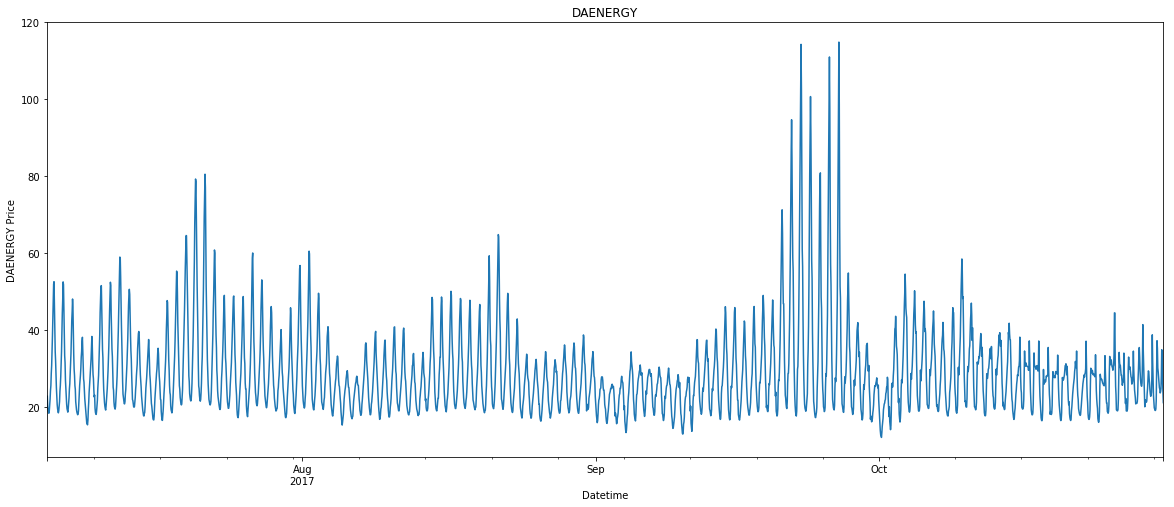

In [231]:
plt.figure(figsize=(20,8))
df.DAENERGY.plot()
plt.title('DAENERGY')
plt.xlabel('Datetime')
plt.ylabel('DAENERGY Price');

In [232]:
df.head()

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,KVCT,KWRI,KYNG,KZZV,LOAD,DAENERGY,RTENERGY,ISOWIND,OUTAGE,hourofday
dt,,,,,,,,,,,,,,,,,,,,,
2017-07-05 01:00:00,2017-07-05,73,67,63,66,77,83,70,80,69,...,81,67,68,70,78515,22.89,22.06,4576.170,14310,01:00:00
2017-07-05 02:00:00,2017-07-05,74,63,62,67,81,84,69,84,63,...,80,68,61,66,68721,20.17,19.97,2952.209,13300,02:00:00
2017-07-05 03:00:00,2017-07-05,75,62,62,66,80,82,69,82,62,...,79,68,61,65,65820,19.42,19.41,2791.408,13300,03:00:00
2017-07-05 04:00:00,2017-07-05,76,61,62,66,78,80,69,80,61,...,78,67,60,64,64262,18.74,19.09,2525.984,13300,04:00:00
2017-07-05 05:00:00,2017-07-05,77,59,61,66,75,79,68,80,60,...,77,67,59,64,64020,18.49,18.64,2520.608,13300,05:00:00


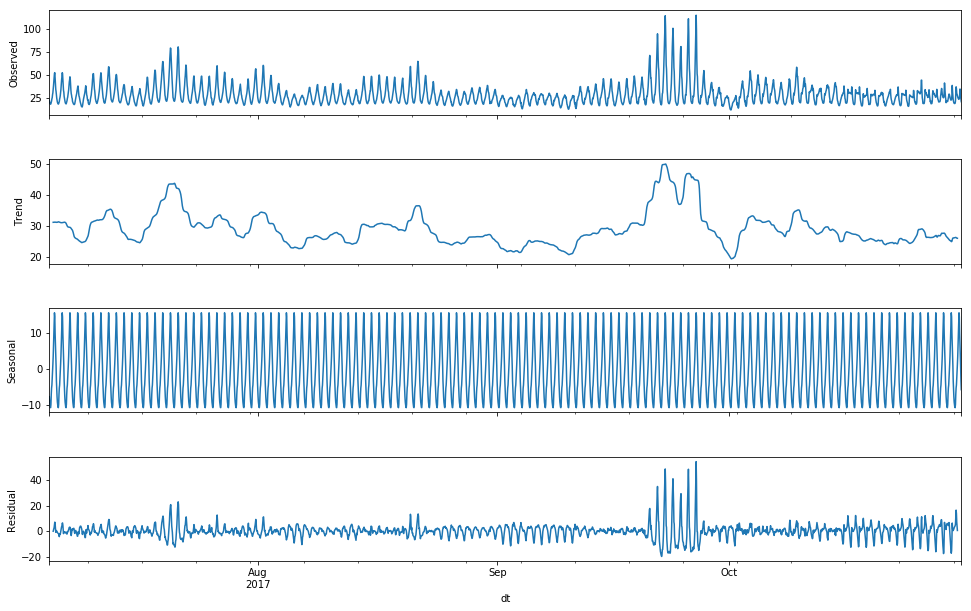

In [233]:
decomposition = seasonal_decompose(df.DAENERGY, freq = 24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 10)

In [234]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=24)
    #rolstd = pd.rolling_std(timeseries, window=24)
    rolmean = pd.Series.rolling(timeseries, window=24, center=False).mean()
    rolstd = pd.Series.rolling(timeseries, window=24, center=False).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

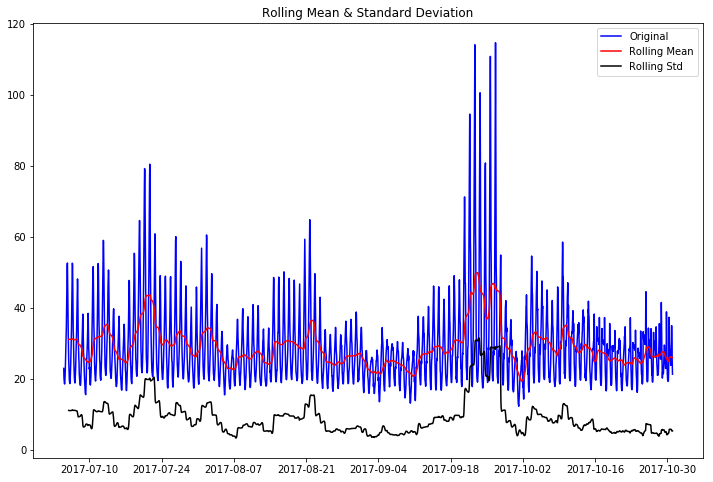

Results of Dickey-Fuller Test:
Test Statistic                   -3.517626
p-value                           0.007546
#Lags Used                       26.000000
Number of Observations Used    2805.000000
Critical Value (1%)              -3.432683
Critical Value (5%)              -2.862571
Critical Value (10%)             -2.567319
dtype: float64


In [235]:
test_stationarity(df.DAENERGY)

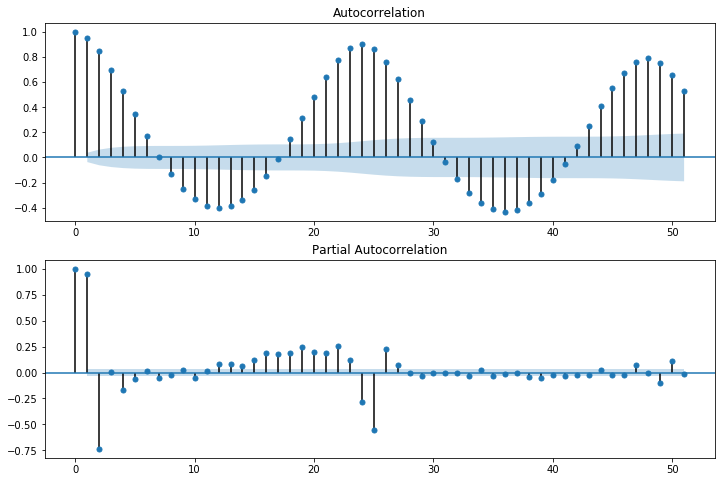

In [236]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.DAENERGY.iloc[50:], lags=51, ax=ax1, alpha = 0.05)#25,26
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.DAENERGY.iloc[50:], lags=51, ax=ax2,alpha = 0.05)

### SARIMAX MODEL

In [237]:
def create_model(dd, date_predict, exogens):
    mod = sm.tsa.statespace.SARIMAX(dd.DAENERGY,exogen = dd[exogens], trend='n', order=(0,1,0), seasonal_order=(1,1,1,24))
    results = mod.fit()
    print (results.summary())
    pred = results.forecast(24)
    real = df[date_predict].DAENERGY
    RMSE=get_rmse(pred,real)
    plt.plot(df[date_predict].index, real,'g',pred.index,pred,'r' )
    plt.title('RMSE = {:.2f}'.format(RMSE))
    plt.xlabel('time')
    plt.ylabel('Price DAENERGY')
    return results, mod

def get_rmse(pred, real):
    return np.sqrt(((pred-real)**2).sum()/(pred.shape[0]))

In [238]:
temps = []
for col in df.columns.values:
    if len(col)==4:
        temps.append(col)
        
def check_bad_data(df):
    temp = df.groupby('TRADEDATE').count()['HOUROFWEEK']
    temp[temp<24]
    df[df['TRADEDATE'] == '2017-10-25']
    

#### Training the Model
Using historical data until one day before of the day to predict

                                 Statespace Model Results                                 
Dep. Variable:                           DAENERGY   No. Observations:                 2111
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 24)   Log Likelihood               -3915.673
Date:                            Tue, 28 Nov 2017   AIC                           7837.347
Time:                                    19:59:37   BIC                           7854.311
Sample:                                07-05-2017   HQIC                          7843.559
                                     - 09-30-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.7554      0.010     76.941      0.000       0.736       0.775
ma.S.L24      -0.9996      0.275   

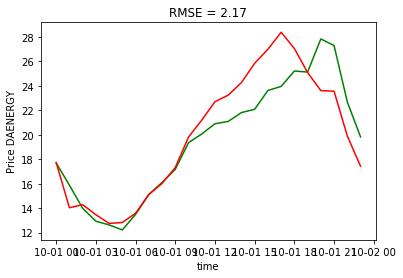

In [239]:
res, mod = create_model(df[:'2017-09-30'],'2017-10-01',temps)

In [240]:
fcast = res.get_forecast(24)
fcast_ci= fcast.conf_int(alpha=0.25)
print(fcast.predicted_mean)
print('')
print('75% of Confidence Interval')
print(fcast_ci)

2017-10-01 00:00:00    17.731409
2017-10-01 01:00:00    14.033491
2017-10-01 02:00:00    14.283525
2017-10-01 03:00:00    13.461540
2017-10-01 04:00:00    12.751209
2017-10-01 05:00:00    12.825707
2017-10-01 06:00:00    13.581996
2017-10-01 07:00:00    15.110983
2017-10-01 08:00:00    16.014146
2017-10-01 09:00:00    17.320801
2017-10-01 10:00:00    19.803808
2017-10-01 11:00:00    21.197621
2017-10-01 12:00:00    22.698929
2017-10-01 13:00:00    23.236736
2017-10-01 14:00:00    24.264580
2017-10-01 15:00:00    25.839901
2017-10-01 16:00:00    26.986268
2017-10-01 17:00:00    28.377817
2017-10-01 18:00:00    27.048691
2017-10-01 19:00:00    25.084450
2017-10-01 20:00:00    23.608655
2017-10-01 21:00:00    23.559916
2017-10-01 22:00:00    19.901571
2017-10-01 23:00:00    17.426787
Freq: H, dtype: float64

75% of Confidence Interval
                     lower DAENERGY  upper DAENERGY
2017-10-01 00:00:00       15.929310       19.533509
2017-10-01 01:00:00       11.484938       16.582045


In [241]:
predict = fcast
predict_ci = fcast_ci

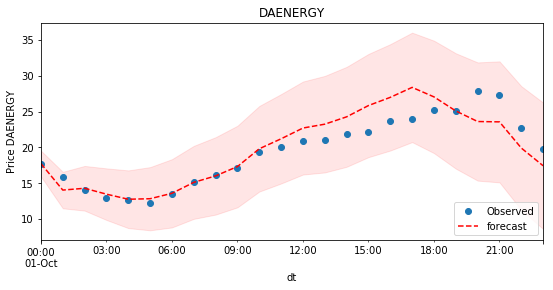

In [242]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 24
ax.set(title='DAENERGY', xlabel='Date', ylabel='Price DAENERGY')

# Plot data points
df.loc['2017-10-01', 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2017-10-01'].plot(ax=ax, style='r--', label='forecast')
ci = predict_ci.loc['2017-10-01']
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
legend = ax.legend(loc='lower right')

### AdaBoost Regressor

In [243]:
from sklearn.ensemble import AdaBoostRegressor

#### Cleaning Data for SKLEARN AdaBoost Model

The model will be trained with the historical data until one day before of the prediction required:

In [244]:
sk_df = df[:'2017-08-15'].copy()
sk = sk_df.drop(['TRADEDATE', 'RTENERGY'], axis=1)
sk.hourofday = sk.hourofday.dt.seconds/3600
sk['daybefore'] = sk.DAENERGY.shift(24)
sk = sk.dropna()
y = sk.pop('DAENERGY').values
X = sk.values

#### Creating Model and Training

In [245]:
model = AdaBoostRegressor()
model = model.fit(X,y)

#### Preparing data of 2017-08-16 to make prediction

In [246]:
input_p = df['2017-08-15':'2017-08-16'].copy()
input_p['daybefore'] = input_p.DAENERGY.shift(24)
input_p = input_p.drop(['DAENERGY','TRADEDATE', 'RTENERGY'], axis=1)
input_p.hourofday = input_p.hourofday.dt.seconds/3600
input_p = input_p.dropna()

#### Predictions for 2017-08-16

In [247]:
results = df['2017-08-16'].copy()
pred_ada = model.predict(input_p.values)
results['forecast'] = pred_ada

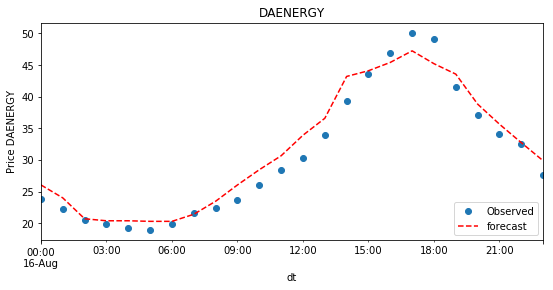

In [248]:
fig, ax = plt.subplots(figsize=(9,4))
npre = 24
ax.set(title='DAENERGY', xlabel='Date', ylabel='Price DAENERGY')

# Plot data points
results.loc['2017-08-16', 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
results.forecast.plot(ax=ax, style='r--', label='forecast')
#ci = predict_ci.loc['2017-08-16']
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
legend = ax.legend(loc='lower right')

In [249]:
RMSE = get_rmse(df['2017-08-16']['DAENERGY'], pred_ada)
print('RMSE for AdaBoost Model: ', RMSE)

RMSE for AdaBoost Model:  2.08763364365


#### Top Features Importance:

In [250]:
input_p.columns.values[np.argsort(model.feature_importances_)[::-1]]


array(['LOAD', 'daybefore', 'KLRD', 'KDSM', 'KDEC', 'KMLI', 'KINK', 'KIND',
       'HOUROFWEEK', 'KFWA', 'KGRB', 'KCOU', 'KMSN', 'KAMA', 'KGFK',
       'KCMI', 'KTEB', 'KDET', 'KELP', 'ISOWIND', 'KSAT', 'hourofday',
       'CYWG', 'KFAR', 'KPHL', 'KEWR', 'OUTAGE', 'KLBB', 'KSGF', 'KCGX',
       'KTTN', 'KAWM', 'KBWI', 'KARR', 'KCID', 'KSTL', 'KJCT', 'KABI',
       'KAUS', 'KDFW', 'KDBQ', 'KDCA', 'KELD', 'KDLH', 'KDMH', 'KDOV',
       'KDTO', 'KDTW', 'KDAL', 'KERI', 'KESF', 'KEVV', 'KFDK', 'KDAY',
       'KUNV', 'KCVG', 'KCRW', 'K2G4', 'KABE', 'KACT', 'KACY', 'KADS',
       'KAKR', 'KANJ', 'KAOO', 'KARB', 'KATT', 'KAVP', 'KBAZ', 'KBIS',
       'KBPT', 'KBRO', 'KBTR', 'KCAK', 'KCGI', 'KFSD', 'KCLE', 'KCLL',
       'KCMH', 'KCRP', 'KCKB', 'KGRR', 'KFST', 'KRDU', 'KMRB', 'KMSP',
       'KMSY', 'KMWL', 'KODO', 'KORD', 'KORF', 'KOXB', 'KPIA', 'KPIT',
       'KPRX', 'KRDG', 'KRFD', 'KVCT', 'KRIC', 'KROA', 'KSBN', 'KSBY',
       'KSJT', 'KSMQ', 'KSPI', 'KSPS', 'KSTC', 'KSUX', 'KTOL', 'KTYR',
 

In [251]:
def train_and_predict(df,date_predict):
    #Prepartinf data to Train
    #print('Preparing data to Train')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    sk_df = df[:date_limit].copy()
    sk = sk_df.drop(['TRADEDATE', 'RTENERGY'], axis=1)
    sk.hourofday = sk.hourofday.dt.seconds/3600
    sk['daybefore'] = sk.DAENERGY.shift(24)
    sk = sk.dropna()
    y = sk.pop('DAENERGY').values
    X = sk.values
    
    #Training Model
    #print('Training Model')
    model = AdaBoostRegressor(random_state=10)
    model = model.fit(X,y)
    
    #preparing data to Predict
    #print('Preparing data to predict')
    input_p = df[date_limit:date_predict].copy()
    input_p['daybefore'] = input_p.DAENERGY.shift(24)
    input_p = input_p.drop(['DAENERGY','TRADEDATE', 'RTENERGY'], axis=1)
    input_p.hourofday = input_p.hourofday.dt.seconds/3600
    input_p = input_p.dropna()
    
    results = df[date_predict].copy()
    pred_ada = model.predict(input_p.values)
    results['forecast'] = pred_ada
    RMSE = get_rmse(df[date_predict]['DAENERGY'], pred_ada)
    print('RMSE for AdaBoost Model: ', RMSE)
    #preparing to plot
    #print('Ploting results')
    fig, ax = plt.subplots(figsize=(9,4))
    npre = 24
    ax.set(title='DAENERGY '+ 'RMSE: {:.3f} for {}'.format(RMSE, date_predict), xlabel='Date', ylabel='Price DAENERGY')

    # Plot data points
    df.loc[date_predict, 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

    # Plot predictions
    results.forecast.plot(ax=ax, style='r--', label='forecast')
    #ci = predict_ci.loc[date_predict]
    #ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    legend = ax.legend(loc='lower right')
    
    

    return results, RMSE

def create_date_range(start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    dates = []
    cur_dt = start_dt
    dates.append(start_date)
    while cur_dt<end_dt:
        cur_dt = cur_dt + datetime.timedelta(days=1)
        dates.append(cur_dt.strftime('%Y-%m-%d'))
    return dates

RMSE for AdaBoost Model:  4.04358185934


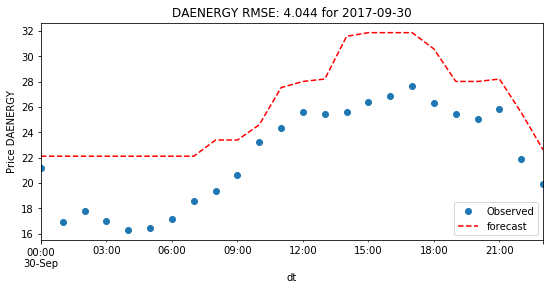

In [252]:
res, rmse = train_and_predict(df,'2017-09-30')

Working for date 2017-08-01
RMSE for AdaBoost Model:  3.43976820954
Working for date 2017-08-02
RMSE for AdaBoost Model:  1.62177473737
Working for date 2017-08-03
RMSE for AdaBoost Model:  1.65376843737
Working for date 2017-08-04
RMSE for AdaBoost Model:  1.20412306342
Working for date 2017-08-05
RMSE for AdaBoost Model:  2.28809949715
Working for date 2017-08-06
RMSE for AdaBoost Model:  1.47901443188
Working for date 2017-08-07
RMSE for AdaBoost Model:  2.58674500865
Working for date 2017-08-08
RMSE for AdaBoost Model:  1.44758574518
Working for date 2017-08-09
RMSE for AdaBoost Model:  2.06257327443
Working for date 2017-08-10
RMSE for AdaBoost Model:  1.64689094548
Working for date 2017-08-11
RMSE for AdaBoost Model:  1.59493766841
Working for date 2017-08-12
RMSE for AdaBoost Model:  1.21842959427
Working for date 2017-08-13
RMSE for AdaBoost Model:  1.56796250374
Working for date 2017-08-14
RMSE for AdaBoost Model:  4.23877661542
Working for date 2017-08-15
RMSE for AdaBoost Mo

/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.2171363956
Working for date 2017-08-23


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.06854598305
Working for date 2017-08-24


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.8169924062
Working for date 2017-08-25


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.43727288445
Working for date 2017-08-26


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.99539255161
Working for date 2017-08-27


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.08683967647
Working for date 2017-08-28


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.37574473032
Working for date 2017-08-29


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.6103682544
Working for date 2017-08-30


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.74564849783
Working for date 2017-08-31


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.25640366475


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


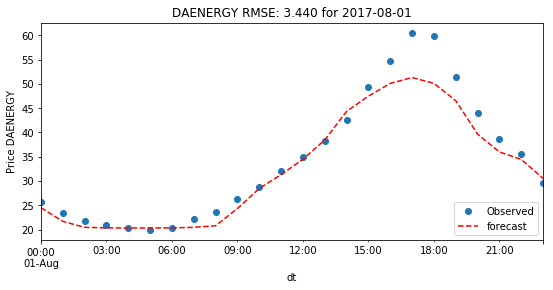

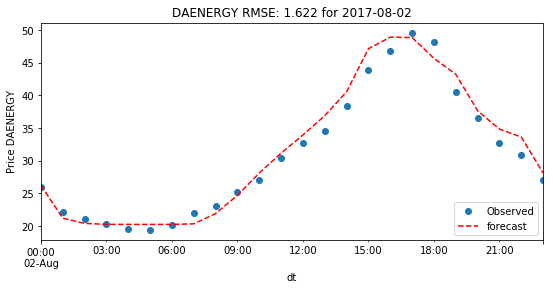

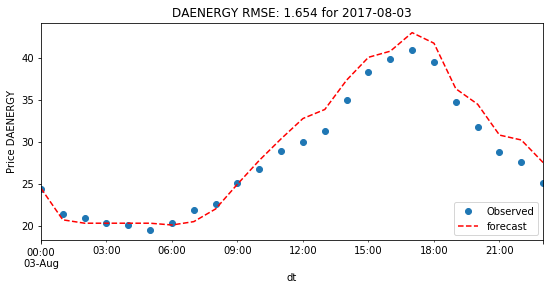

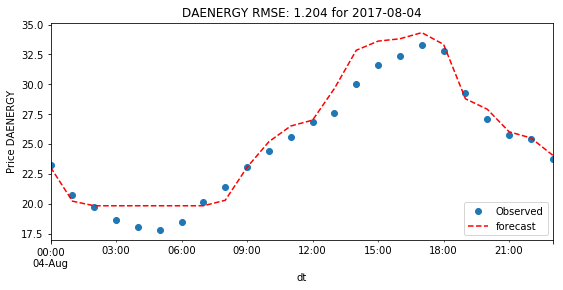

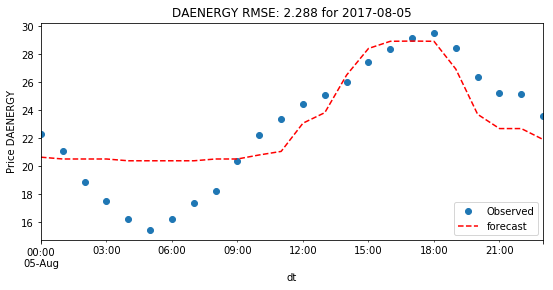

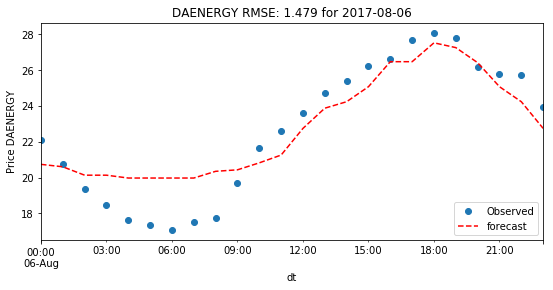

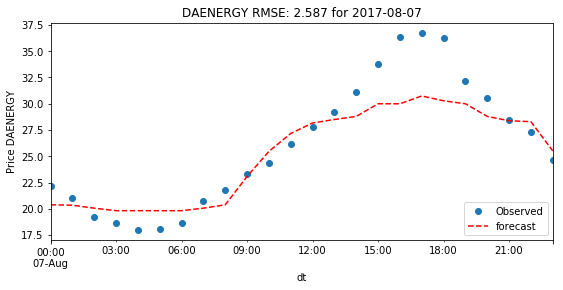

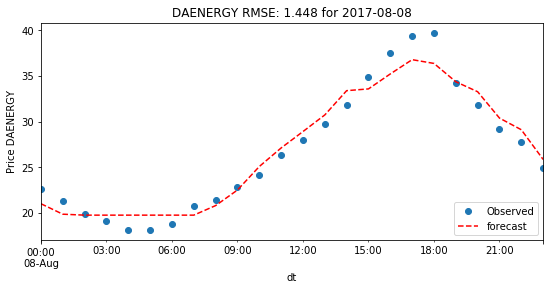

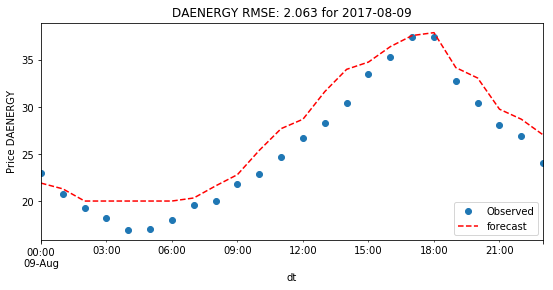

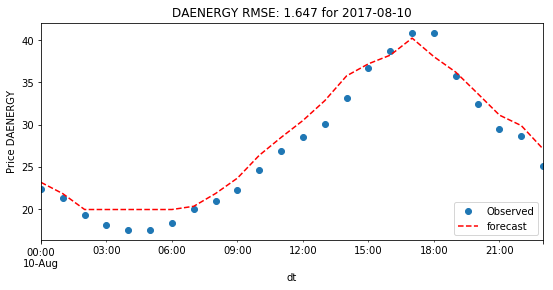

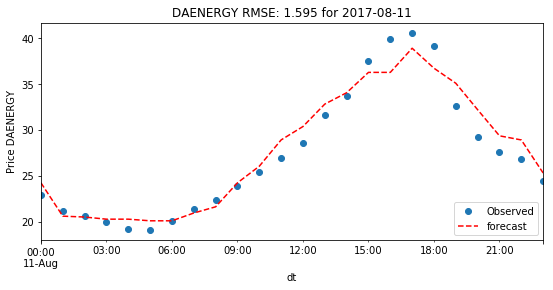

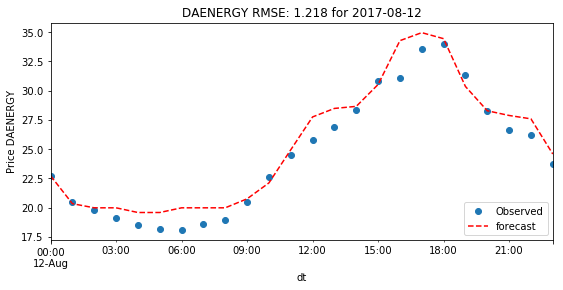

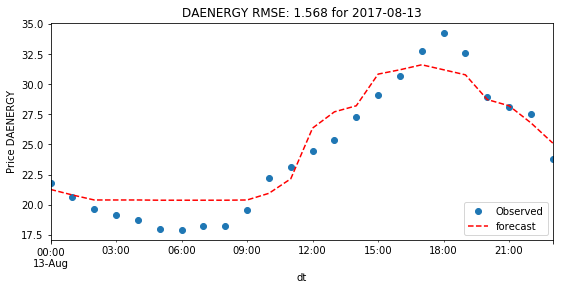

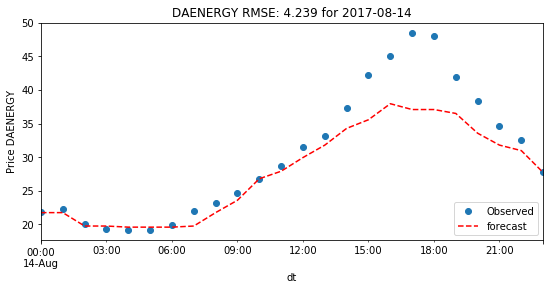

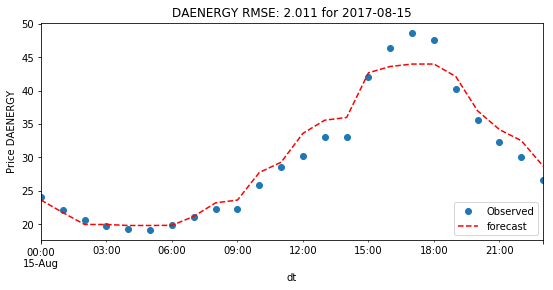

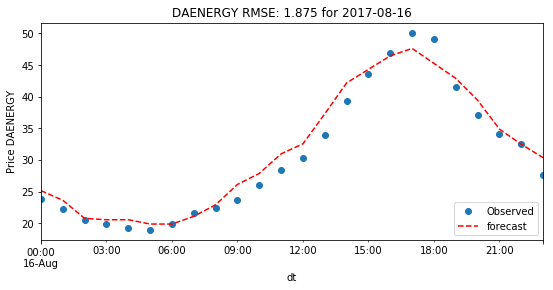

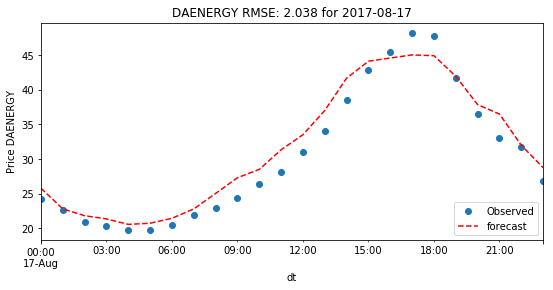

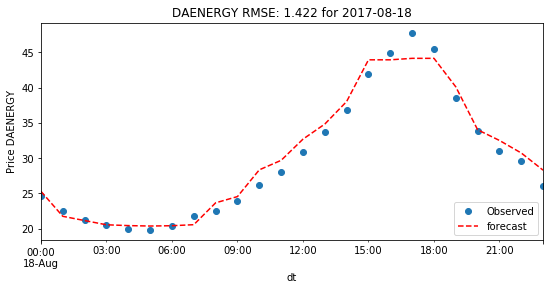

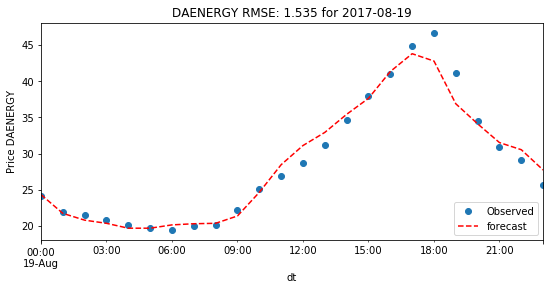

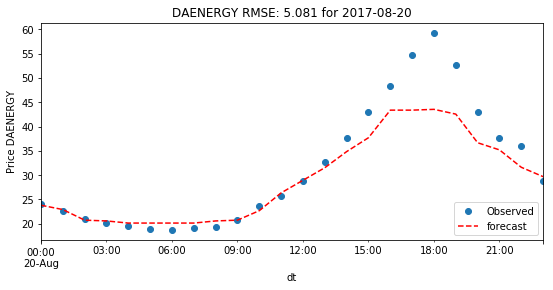

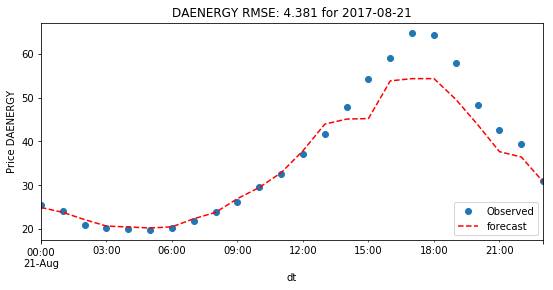

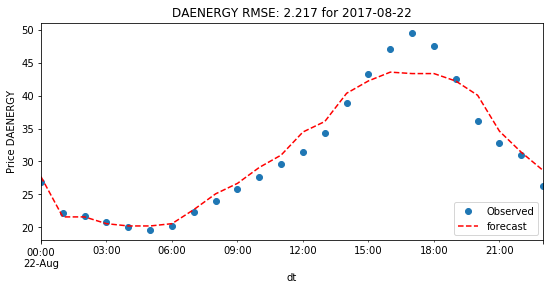

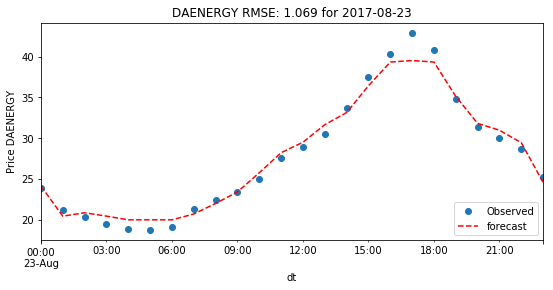

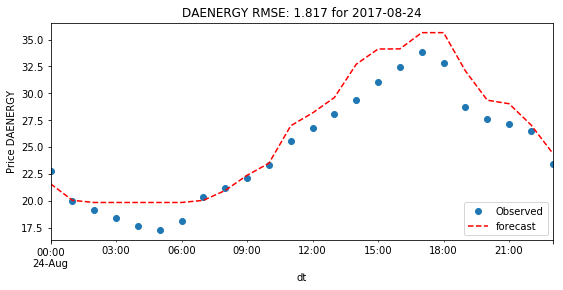

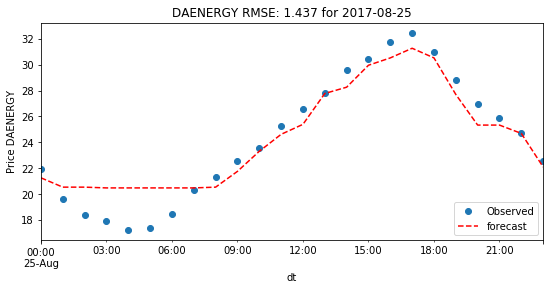

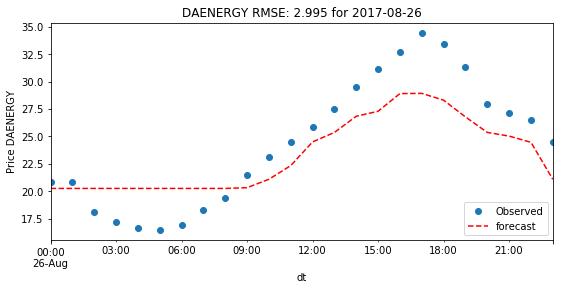

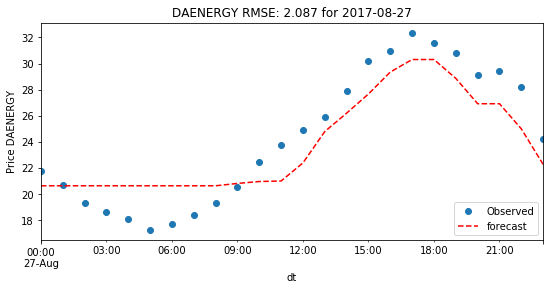

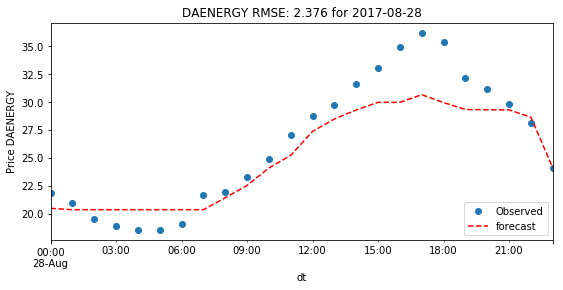

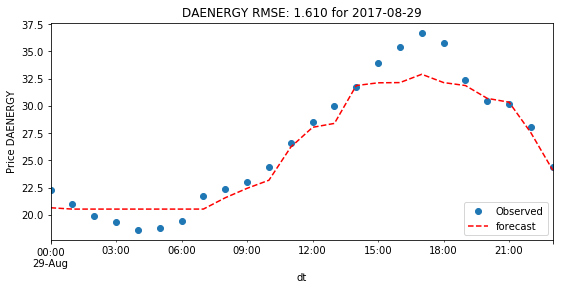

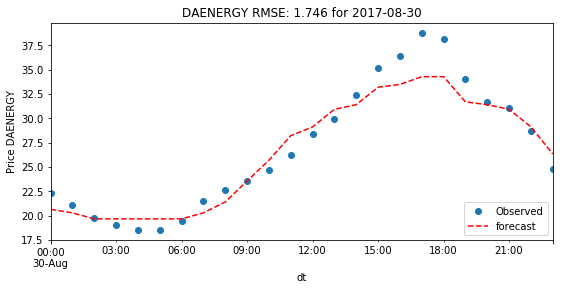

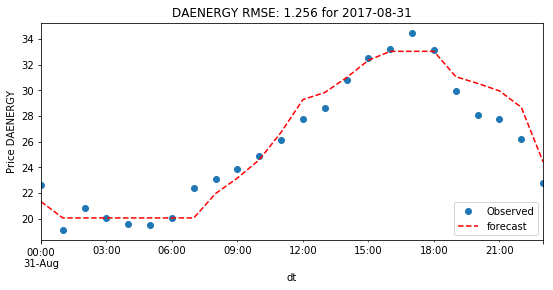

In [253]:
rmses = []
for dt in create_date_range('2017-08-01', '2017-08-31'):
    print('Working for date {}'.format(dt))
    res, rmse = train_and_predict(df,dt)
    rmses.append(rmse)

Mean RMSE for september: 2.0969116482115195


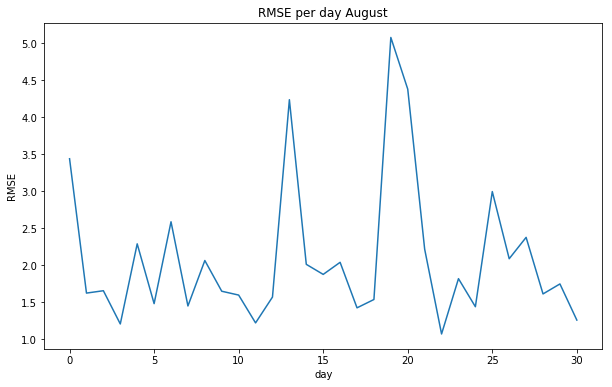

In [254]:
plt.figure(figsize = (10,6))
plt.plot(rmses)
plt.title('RMSE per day August')
plt.xlabel('day')
plt.ylabel('RMSE')
mean_august = np.array(rmses).mean()
print('Mean RMSE for september: {}'.format(mean_august))

Working for date 2017-09-01
RMSE for AdaBoost Model:  2.62906798024
Working for date 2017-09-02
RMSE for AdaBoost Model:  2.12656500461
Working for date 2017-09-03
RMSE for AdaBoost Model:  2.05149779455
Working for date 2017-09-04
RMSE for AdaBoost Model:  2.99206436714
Working for date 2017-09-05
RMSE for AdaBoost Model:  1.82715503991
Working for date 2017-09-06
RMSE for AdaBoost Model:  1.74592074214
Working for date 2017-09-07
RMSE for AdaBoost Model:  1.34324188507
Working for date 2017-09-08
RMSE for AdaBoost Model:  1.40719484682
Working for date 2017-09-09
RMSE for AdaBoost Model:  2.20611070649
Working for date 2017-09-10
RMSE for AdaBoost Model:  2.82624035776
Working for date 2017-09-11
RMSE for AdaBoost Model:  4.2703318957
Working for date 2017-09-12
RMSE for AdaBoost Model:  2.06860292481
Working for date 2017-09-13
RMSE for AdaBoost Model:  2.42415931547
Working for date 2017-09-14
RMSE for AdaBoost Model:  3.51307067943
Working for date 2017-09-15
RMSE for AdaBoost Mod

/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  10.9047771862
Working for date 2017-09-23


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  9.44242445909
Working for date 2017-09-24


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  8.75227327607
Working for date 2017-09-25


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  14.8657163562
Working for date 2017-09-26


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  11.5466384675
Working for date 2017-09-27


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  12.2703301352
Working for date 2017-09-28


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.59147430739
Working for date 2017-09-29


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.36370151633
Working for date 2017-09-30


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  4.04358185934


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


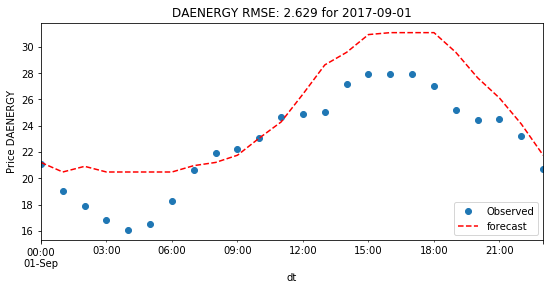

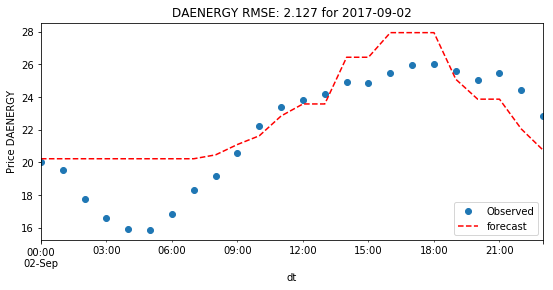

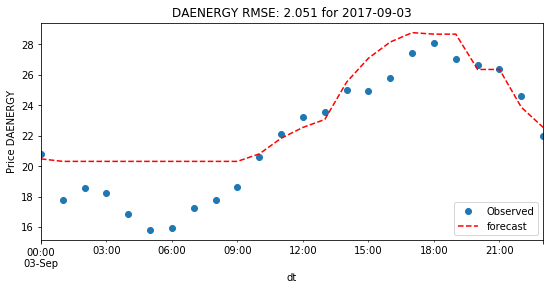

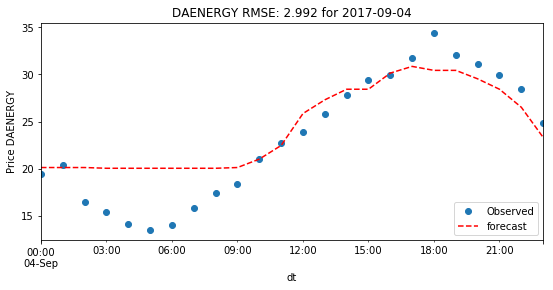

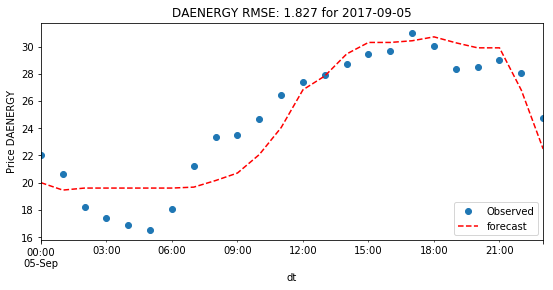

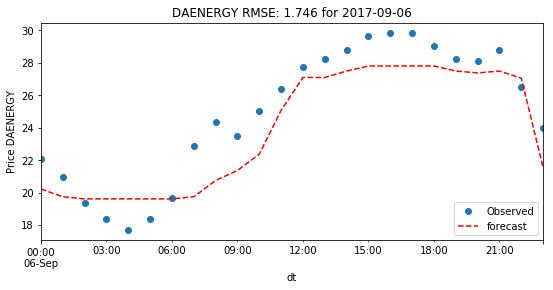

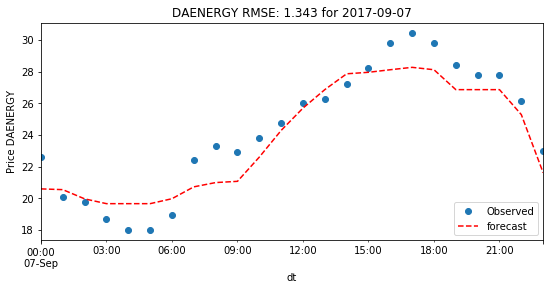

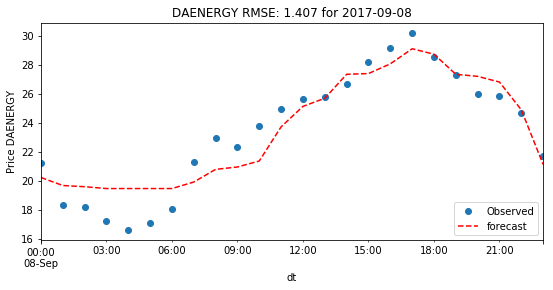

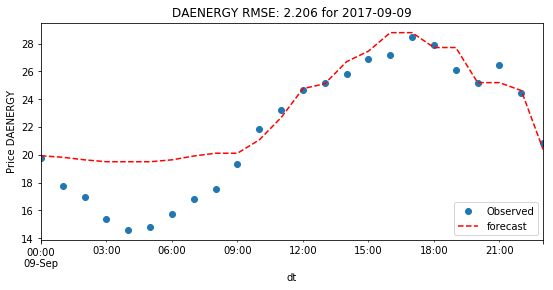

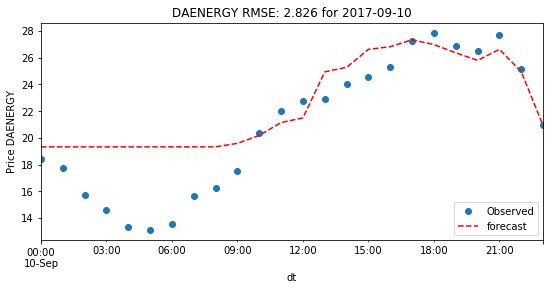

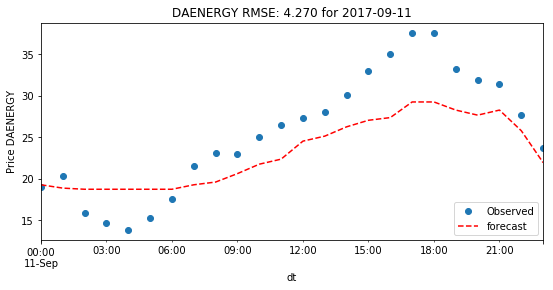

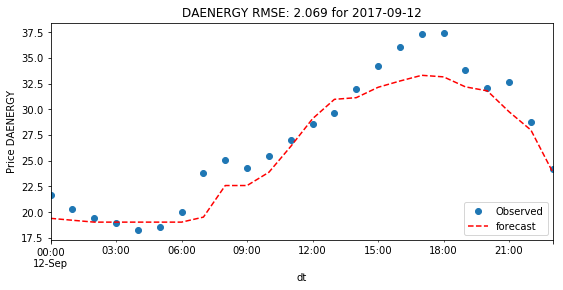

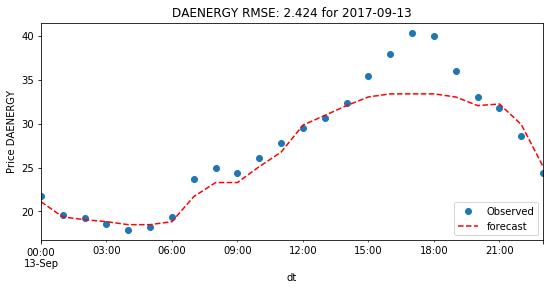

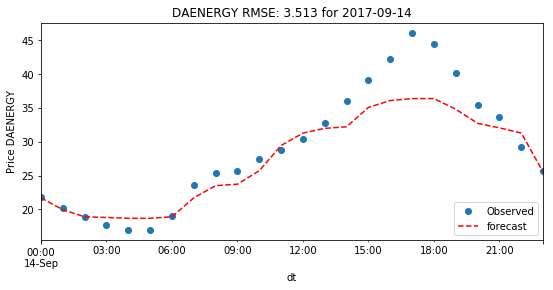

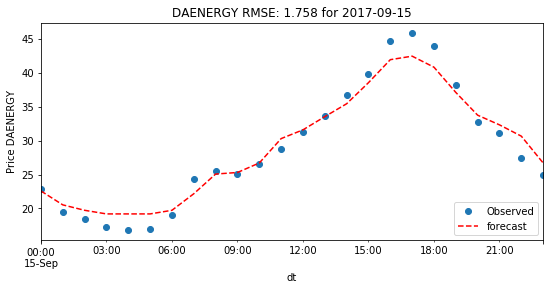

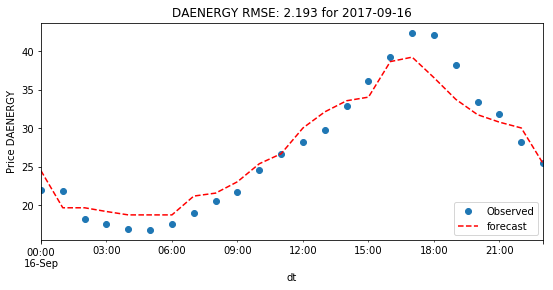

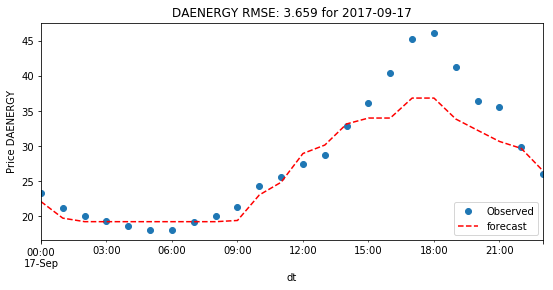

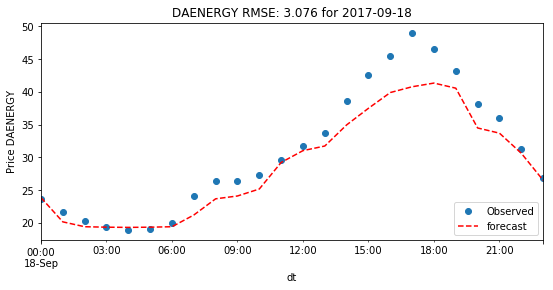

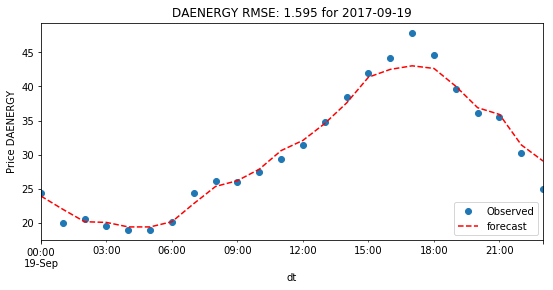

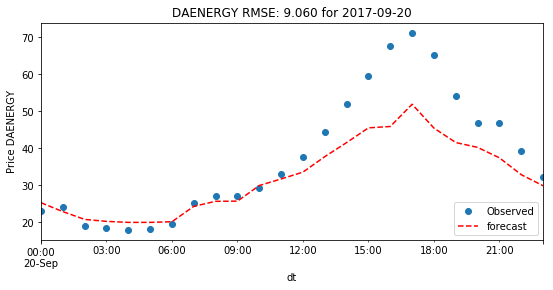

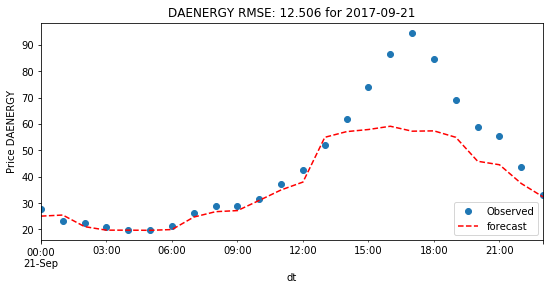

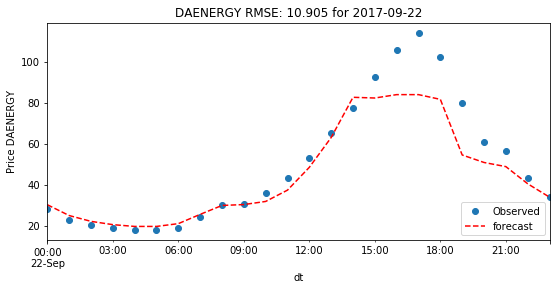

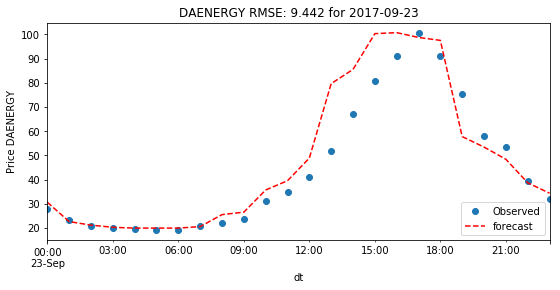

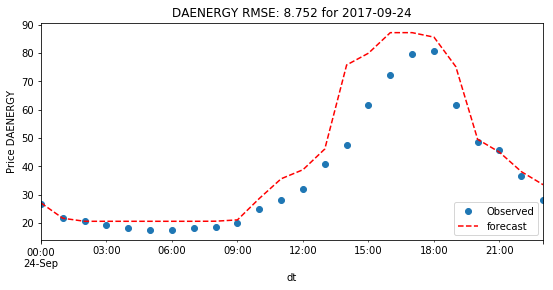

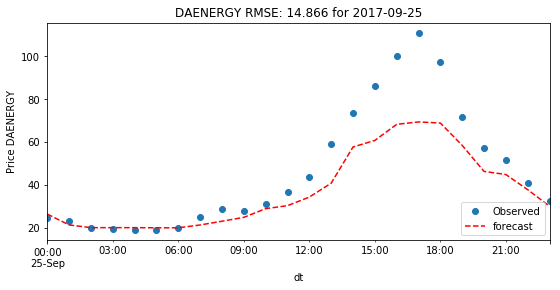

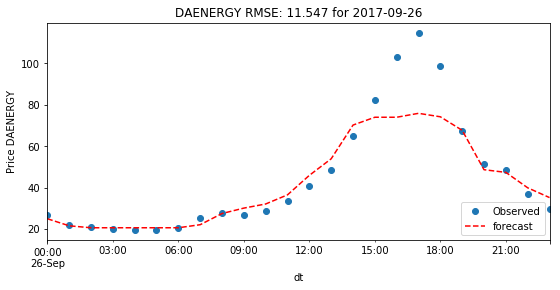

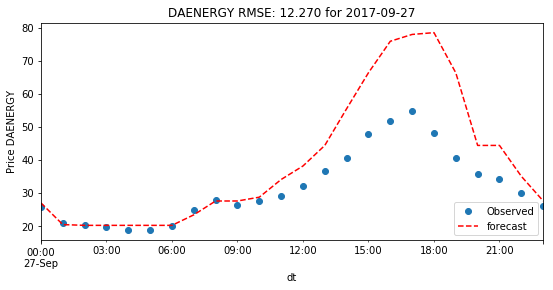

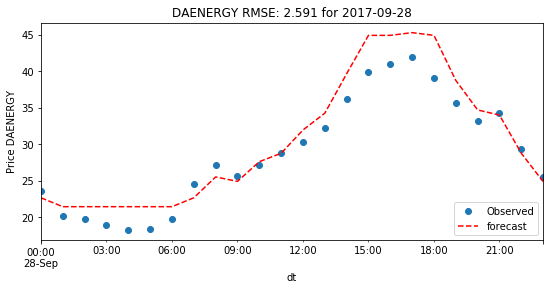

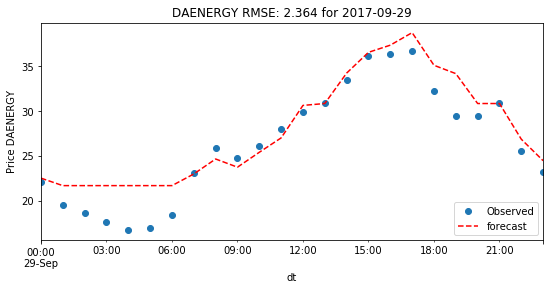

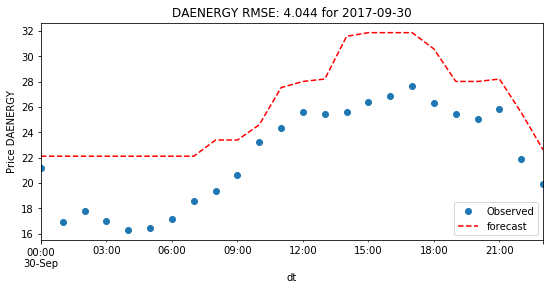

In [255]:
rmses = []
for dt in create_date_range('2017-09-01', '2017-09-30'):
    print('Working for date {}'.format(dt))
    res, rmse = train_and_predict(df,dt)
    rmses.append(rmse)



Mean RMSE for september: 4.801943825877179


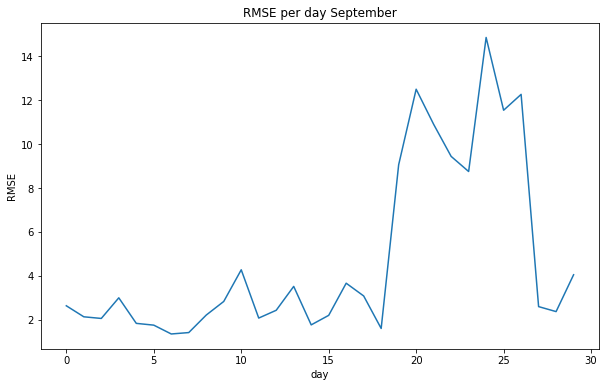

In [256]:
plt.figure(figsize = (10,6))
plt.plot(rmses)
plt.title('RMSE per day September')
plt.xlabel('day')
plt.ylabel('RMSE')
mean_september = np.array(rmses).mean()
print('Mean RMSE for september: {}'.format(mean_september))

In [266]:
def train_model(df,date_predict,model):
    #Prepartinf data to Train
    #print('Preparing data to Train')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    sk_df = df[:date_limit].copy()
    sk = sk_df.drop(['TRADEDATE', 'RTENERGY'], axis=1)
    sk.hourofday = sk.hourofday.dt.seconds/3600
    #sk['daybefore'] = sk.DAENERGY.shift(24)
    sk['weekbefore'] = sk.DAENERGY.shift(24*7)
    #sk['p_36'] = sk.DAENERGY.shift(36)
    sk['p_48'] = sk.DAENERGY.shift(48)
    #sk['p_60'] = sk.DAENERGY.shift(60)
    sk['p_72'] = sk.DAENERGY.shift(72)
    sk['delta_load'] = sk['LOAD'] - sk['LOAD'].shift(24)
    
    sk = sk.dropna()
    y = sk.pop('DAENERGY').values
    X = sk.values
    
    #Training Model
    #print('Training Model')
    model = model.fit(X,y)
    return model, sk

def predict_model(df,date_predict,model):
    #preparing data to Predict
    #print('Preparing data to predict')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')

    df['weekbefore'] = df.DAENERGY.shift(24*7)
    #df['p_36'] = df.DAENERGY.shift(36)
    df['p_48'] = df.DAENERGY.shift(48)
    #df['p_60'] = df.DAENERGY.shift(60)
    df['p_72'] = df.DAENERGY.shift(72)
    df['delta_load'] = df['LOAD'] - df['LOAD'].shift(24)
    
    #input_p = df[date_limit:date_predict].copy()
    #input_p['daybefore'] = input_p.DAENERGY.shift(24)
    input_p = df[date_predict].copy()
    
    input_p = input_p.drop(['DAENERGY','TRADEDATE', 'RTENERGY'], axis=1)
    input_p.hourofday = input_p.hourofday.dt.seconds/3600
    input_p = input_p.dropna()
    
    results = df[date_predict].copy()
    pred_ada = model.predict(input_p.values)
    results['forecast'] = pred_ada
    RMSE = get_rmse(df[date_predict]['DAENERGY'], pred_ada)
    print('RMSE for Model: ', RMSE)
    #preparing to plot
    #print('Ploting results')
    fig, ax = plt.subplots(figsize=(9,4))
    npre = 24
    ax.set(title='DAENERGY '+ 'RMSE: {:.3f} for {}'.format(RMSE, date_predict), xlabel='Date', ylabel='Price DAENERGY')

    # Plot data points
    df.loc[date_predict, 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

    # Plot predictions
    results.forecast.plot(ax=ax, style='r--', label='forecast')
    #ci = predict_ci.loc[date_predict]
    #ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    legend = ax.legend(loc='lower right')
    
    

    return results, RMSE, input_p.columns

In [264]:
date_predict = '2017-09-30'
date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')

df['weekbefore'] = df.DAENERGY.shift(24*7)
#df['p_36'] = df.DAENERGY.shift(36)
df['p_48'] = df.DAENERGY.shift(48)
#df['p_60'] = df.DAENERGY.shift(60)
df['p_72'] = df.DAENERGY.shift(72)
df['delta_load'] = df['LOAD'] - df['LOAD'].shift(24)


input_p = df[date_limit:date_predict].copy()
#input_p['daybefore'] = input_p.DAENERGY.shift(24)

input_p = input_p.drop(['DAENERGY','TRADEDATE', 'RTENERGY'], axis=1)
input_p.hourofday = input_p.hourofday.dt.seconds/3600
input_p = input_p.dropna()
results = df[date_predict].copy()
pred_ada = model.predict(input_p.values)




In [265]:
pred_ada.shape

(48,)

In [263]:
results.shape

(24, 147)

RMSE for Model:  2.45018737


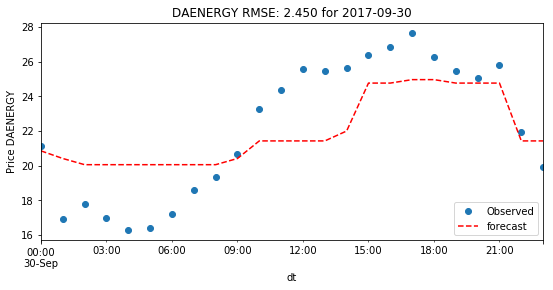

In [287]:
date_predict = '2017-09-30'
model = AdaBoostRegressor(n_estimators=10,random_state=10)
model, newdf = train_model(df,date_predict,model)
res,rmse,cols = predict_model(df,date_predict,model)

Working for date 2017-09-01
RMSE for Model:  2.23761644326
Working for date 2017-09-02
RMSE for Model:  2.38023987619
Working for date 2017-09-03
RMSE for Model:  2.2681477421
Working for date 2017-09-04
RMSE for Model:  3.09386786502
Working for date 2017-09-05
RMSE for Model:  1.5156083904
Working for date 2017-09-06
RMSE for Model:  2.2057143675
Working for date 2017-09-07
RMSE for Model:  1.14314461726
Working for date 2017-09-08
RMSE for Model:  1.32137570418
Working for date 2017-09-09
RMSE for Model:  2.35763780704
Working for date 2017-09-10
RMSE for Model:  2.96071028035
Working for date 2017-09-11
RMSE for Model:  4.15517126659
Working for date 2017-09-12
RMSE for Model:  3.17618668901
Working for date 2017-09-13
RMSE for Model:  3.22290045438
Working for date 2017-09-14
RMSE for Model:  4.32691470173
Working for date 2017-09-15
RMSE for Model:  2.60995147892
Working for date 2017-09-16
RMSE for Model:  2.37765398638
Working for date 2017-09-17
RMSE for Model:  3.89968095386


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


12.777382471
Working for date 2017-09-22
RMSE for Model:  9.45465063889
Working for date 2017-09-23
RMSE for Model:  12.3587105349
Working for date 2017-09-24
RMSE for Model: 

/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 6.24180273174
Working for date 2017-09-25
RMSE for Model:  6.52953177185
Working for date 2017-09-26


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for Model:  11.047514867
Working for date 2017-09-27


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for Model:  3.00426060811
Working for date 2017-09-28
RMSE for Model: 

/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 7.99028988373
Working for date 2017-09-29
RMSE for Model:  2.89155668303
Working for date 2017-09-30
RMSE for Model:  4.46288003975


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


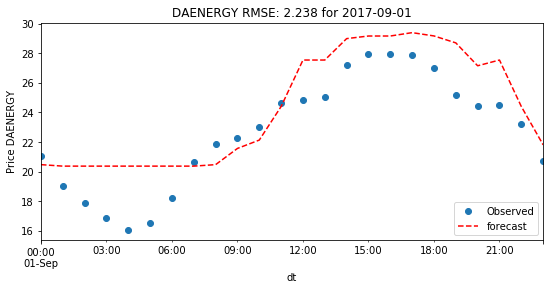

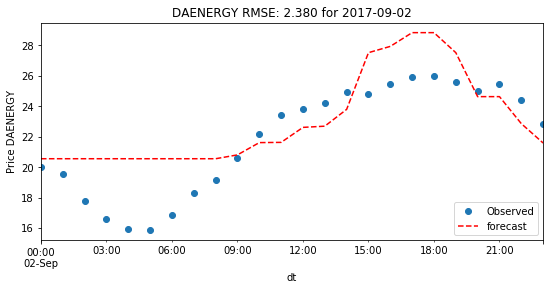

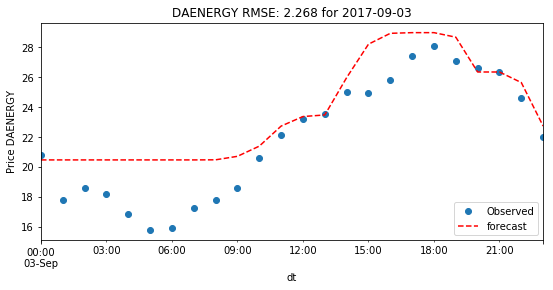

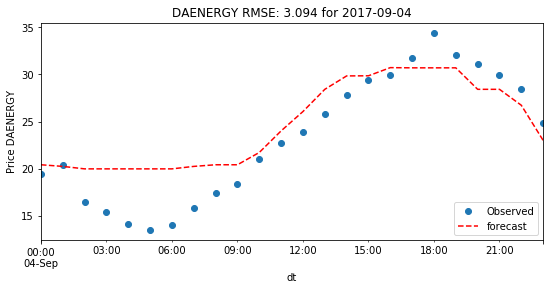

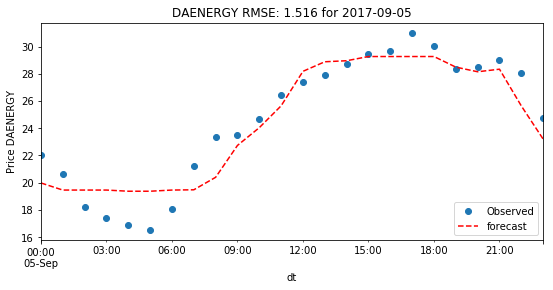

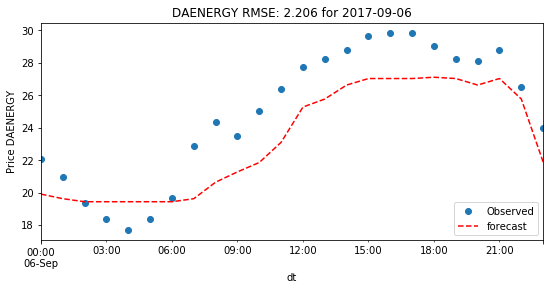

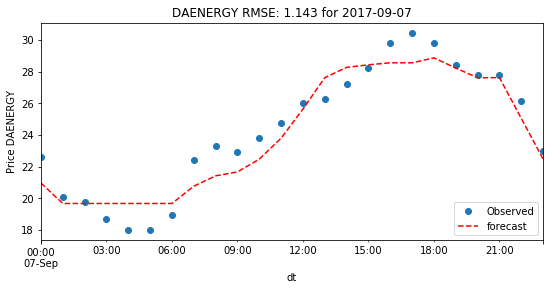

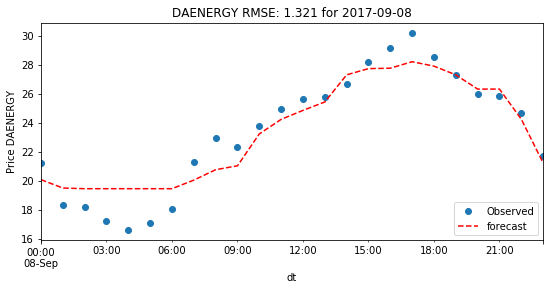

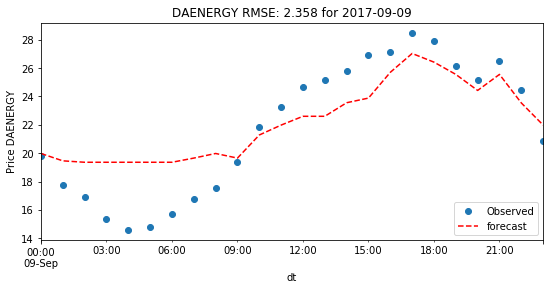

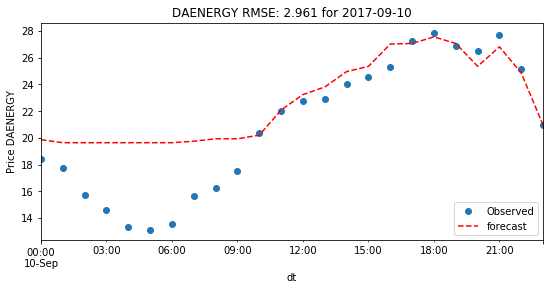

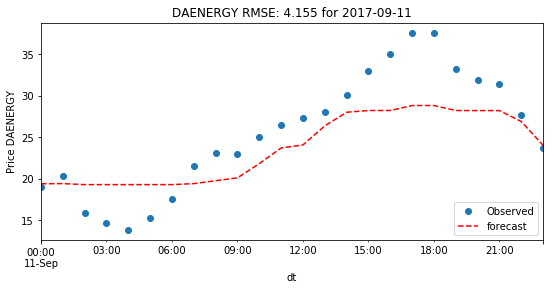

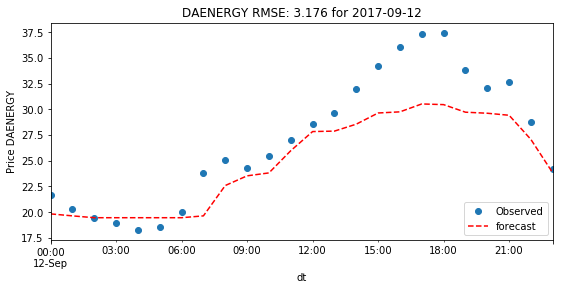

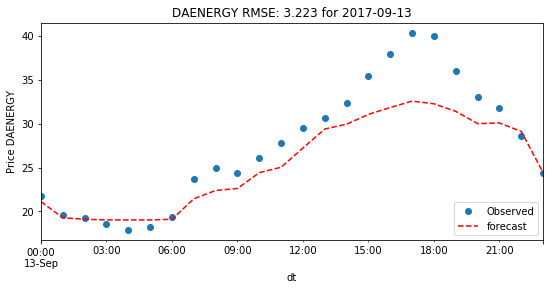

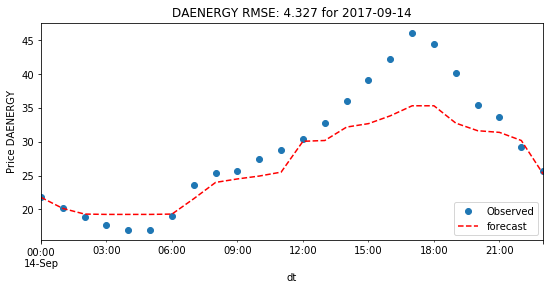

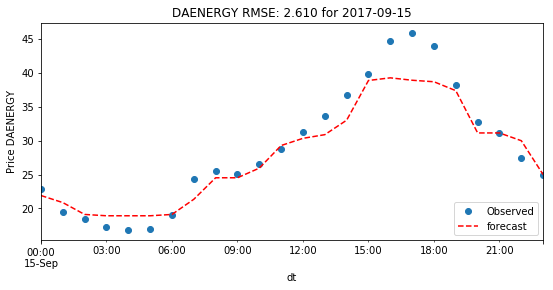

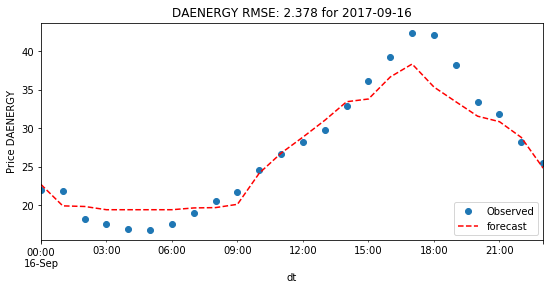

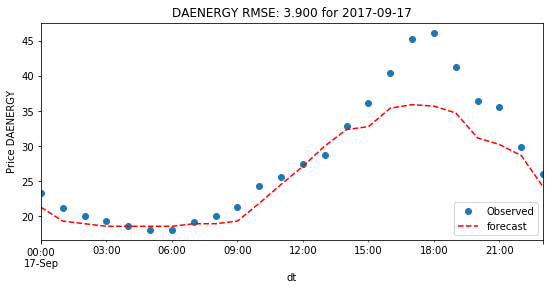

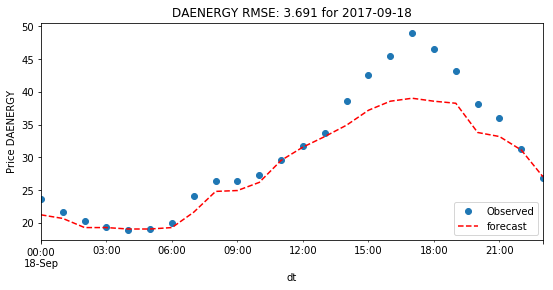

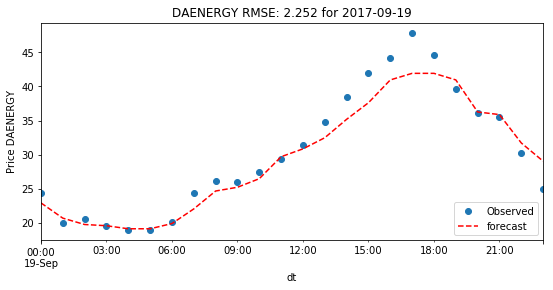

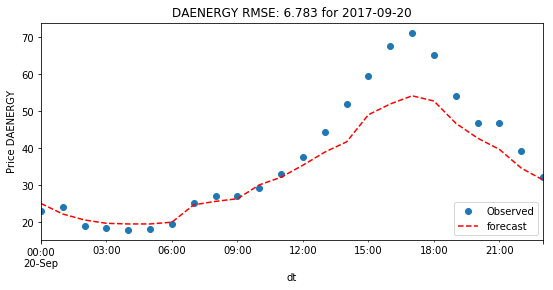

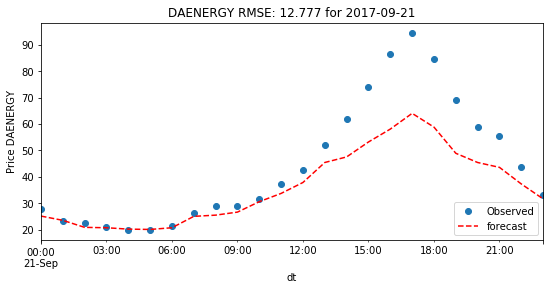

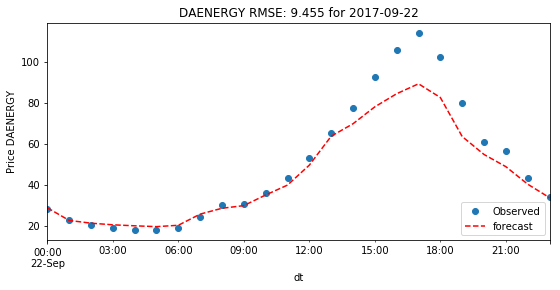

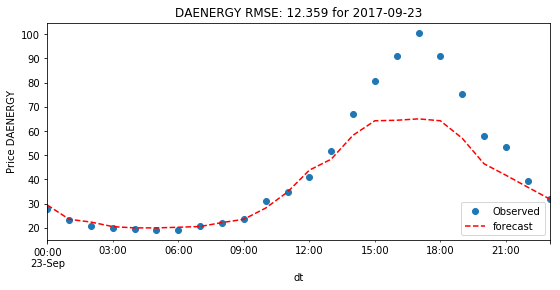

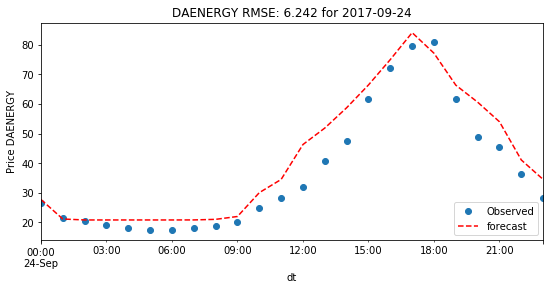

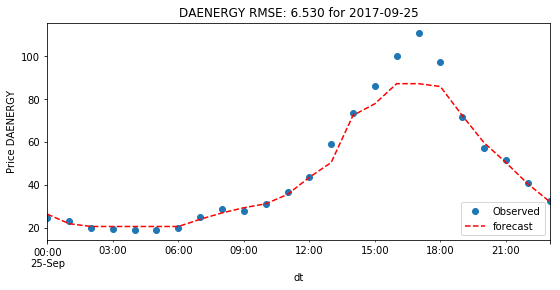

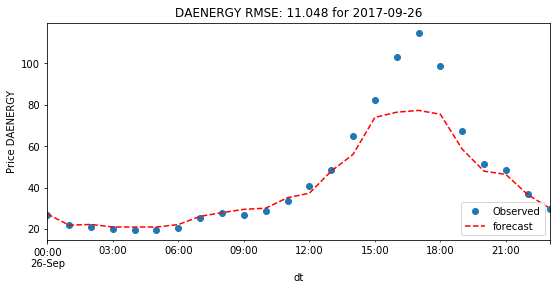

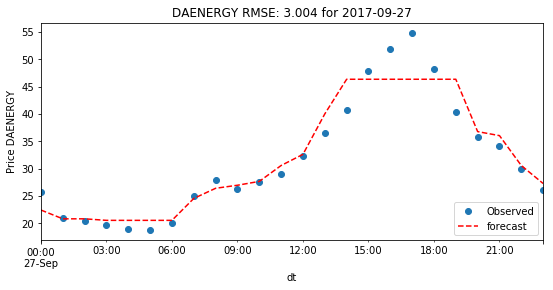

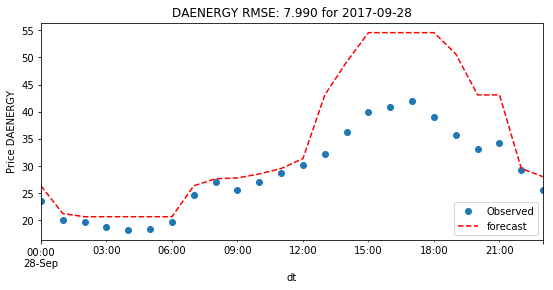

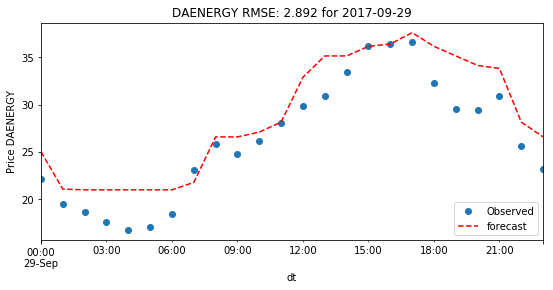

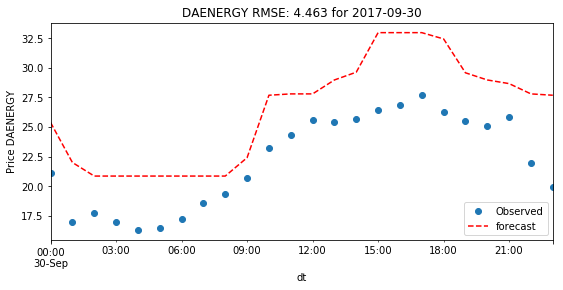

In [288]:
rmses = []
for dt in create_date_range('2017-09-01', '2017-09-30'):
    print('Working for date {}'.format(dt))
    model = AdaBoostRegressor(random_state=10)
    model, newdf = train_model(df,dt,model)
    res, rmse,cols = predict_model(df,dt,model)
    rmses.append(rmse)

Mean RMSE for september: 4.49124985290413


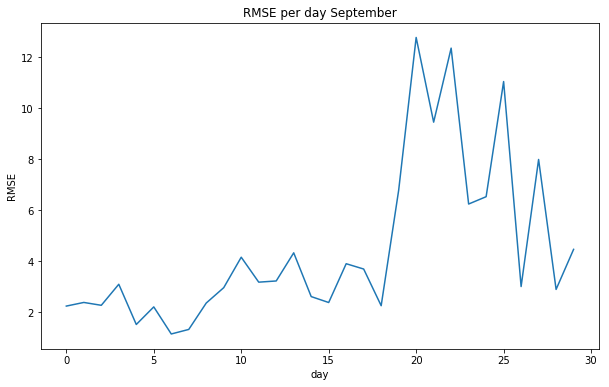

In [289]:
plt.figure(figsize = (10,6))
plt.plot(rmses)
plt.title('RMSE per day September')
plt.xlabel('day')
plt.ylabel('RMSE')
mean_september = np.array(rmses).mean()
print('Mean RMSE for september: {}'.format(mean_september))

In [58]:
print(cols[np.argsort(model.feature_importances_)[::-1]][0:10])

Index(['daybefore', 'LOAD', 'OUTAGE', 'weekbefore', 'KCGX', 'KEWR', 'KANJ',
       'KORF', 'KMKE', 'p_72'],
      dtype='object', name='REGION')


In [290]:
print(cols[np.argsort(model.feature_importances_)[::-1]][0:10])

Index(['LOAD', 'p_48', 'OUTAGE', 'weekbefore', 'Temp_C_0', 'delta_load',
       'Temp_C_2', 'ISOWIND', 'Temp_C_3', 'Temp_C_1'],
      dtype='object', name='REGION')


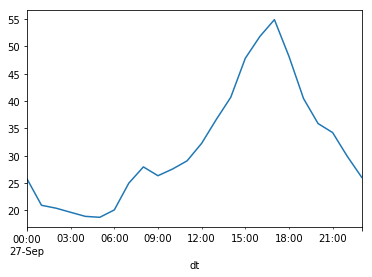

In [37]:
df['2017-09-27']['DAENERGY'].plot()

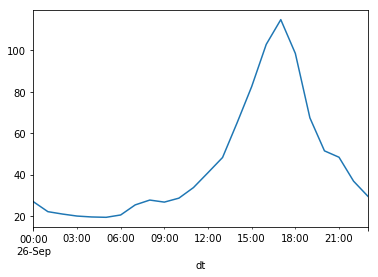

In [42]:
df['2017-09-26']['DAENERGY'].plot()

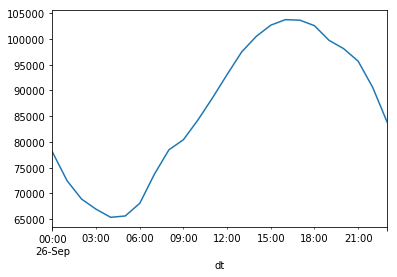

In [45]:
df['2017-09-26']['LOAD'].plot()

In [63]:
wdf = pd.read_csv?

In [271]:
wdf = pd.read_csv('data/wstation.csv', delim_whitespace=True)

In [272]:
wdf

,CALL,LAT,LON,ELEV(M),BEGIN,END
0,ENRS,2.001093e+07,2.005123e+07,NaN,NaN,NaN
1,ENJA,7.093300e+01,-8.667000e+00,9.0,19310101.0,20171126.0
2,ENSO,5.979200e+01,5.341000e+00,48.8,19861120.0,20171126.0
3,ENFR,5.998000e+01,2.250000e+00,48.0,19880320.0,20050228.0
4,ENAS,7.891700e+01,1.193300e+01,8.0,19730101.0,20140523.0
5,ENSB,7.824600e+01,1.546600e+01,26.8,19750929.0,20171126.0
6,ENAN,6.929300e+01,1.614400e+01,13.1,19310103.0,20171126.0
7,ENDU,6.905600e+01,1.854000e+01,76.8,19400713.0,20171126.0
8,ENDR,6.435000e+01,7.800000e+00,0.0,20040510.0,20171126.0
9,ENTC,6.968300e+01,1.891900e+01,9.4,19730101.0,20171126.0


In [273]:
temp_cols = []
for col in cols:
    if len(col)==4 and col not in ['LOAD', 'p_48', 'p_72']:
        temp_cols.append(col)
        

In [274]:
wdf = wdf.drop_duplicates(subset = ['CALL'])

In [275]:
temps = pd.DataFrame(temp_cols)
temps.columns = ['CALL']

In [276]:
result = pd.merge(temps, wdf, how='left', on=['CALL'])


In [277]:
result = result[['CALL','LAT','LON']]
result = result.dropna()


In [278]:
from sklearn.cluster import KMeans

In [279]:
clusters = KMeans(n_clusters = 4).fit(result[['LAT','LON']])

In [280]:
clusters.labels_

array([3, 2, 1, 1, 2, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 0, 1, 3, 1, 1, 1, 2, 2,
       0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 0, 0, 1, 3, 2, 2, 3,
       1, 0, 1, 1, 2, 1, 0, 2, 3, 2, 3, 1, 0, 2, 3, 1, 0, 0, 1, 2, 1, 2, 1,
       2, 0, 1, 3, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 2, 1, 3, 2, 0, 2, 0, 0,
       0, 1, 2, 0, 3, 1, 1, 1, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 2, 1, 0, 2,
       1, 1, 2, 0, 1, 3, 0, 3, 2, 0, 2, 1, 0, 2, 1, 2, 2, 2], dtype=int32)

In [281]:
result['Cluster'] = clusters.labels_

In [282]:
result

,CALL,LAT,LON,Cluster
0,CYWG,49.910,-97.240,3
2,KABE,40.650,-75.448,2
3,KABI,32.411,-99.682,1
4,KACT,31.619,-97.228,1
5,KACY,39.452,-74.567,2
6,KADS,32.969,-96.836,1
7,KAKR,41.038,-81.464,2
8,KAMA,35.230,-101.704,1
9,KANJ,46.479,-84.357,0
10,KAOO,40.296,-78.320,2


In [283]:
df['Temp_C_0']=df[result[result.Cluster==0]['CALL']].mean(axis=1)
df['Temp_C_1']=df[result[result.Cluster==1]['CALL']].mean(axis=1)
df['Temp_C_2']=df[result[result.Cluster==2]['CALL']].mean(axis=1)
df['Temp_C_3']=df[result[result.Cluster==3]['CALL']].mean(axis=1)





In [284]:
df = df.drop(temp_cols, axis=1)

In [285]:
df.shape

(2832, 16)

In [286]:
df['2017-09-25'].LOAD.values - df['2017-09-24'].LOAD.values


array([-2259,  1510,  -891,  -305,   811,  2131,  4799,  9573, 13568,
       12202,  9739,  8516,  6915,  5896,  5201,  4419,  4042,  2838,
        2641,  2793,  3387,  2160,  2915,  1562])